<a href="https://colab.research.google.com/github/rein55/Ensemble-Learning/blob/main/Ensemble_Learning_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import log_loss, mean_squared_error
import xgboost as xgb
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer

## Data exploration

In [ ]:
df = pd.read_csv('Student_performance_data _.csv')

# TODO: Basic data exploration. Use df.shape and df.isnull().sum()
df.isnull().sum()

,0
StudentID,0
Age,0
Gender,0
Ethnicity,0
ParentalEducation,0
StudyTimeWeekly,0
Absences,0
Tutoring,0
ParentalSupport,0
Extracurricular,0


In [ ]:
df.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [ ]:
df['GradeClass'].value_counts()

,count
GradeClass,
4.0,1211
3.0,414
2.0,391
1.0,269
0.0,107


### Define features and targets

In [ ]:
target_column_name = 'GPA'
# TODO: drop target from the dataframe. Use df.drop(target_column_name, axis=1)
X = df.drop(target_column_name, axis=1)

# TODO: use target_column_name as the target variable
y = df[target_column_name]

## Preprocess dataset

### Define categorical and numerical features

In [ ]:
# Separate numerical and categorical features based on the classification
numerical_features = ['Age', 'StudyTimeWeekly', 'Absences', 'GradeClass']
categorical_features = ['StudentID', 'Gender', 'Ethnicity', 'ParentalEducation',
                             'Tutoring', 'ParentalSupport', 'Extracurricular',
                             'Sports', 'Music', 'Volunteering']

In [ ]:
numerical_features

['Age', 'StudyTimeWeekly', 'Absences', 'GradeClass']

In [ ]:
categorical_features

['StudentID',
 'Gender',
 'Ethnicity',
 'ParentalEducation',
 'Tutoring',
 'ParentalSupport',
 'Extracurricular',
 'Sports',
 'Music',
 'Volunteering']

### Define transformers

In [ ]:
# TODO: create numerical preprocessor using sklearn pipeline. Use imputer with
# median strategy and a minmax scaler
numerical_imputer = SimpleImputer(strategy='mean')
scaler = MinMaxScaler()
numeric_transformer = Pipeline(steps=[
    ('imputer', numerical_imputer),
    ('scaler', scaler)
])

preprocessor = ColumnTransformer(
     transformers=[
         ('num', numeric_transformer, numerical_features),
     ])

In [ ]:
# TODO: create a function create_preprocessor() to create the above preprocessor
def create_preprocessor():
     numerical_imputer = SimpleImputer(strategy='median')
     scaler = MinMaxScaler()
     numeric_transformer = Pipeline(steps=[
         ('imputer', numerical_imputer),
         ('scaler', scaler)
     ])

     preprocessor = ColumnTransformer(
         transformers=[
             ('num', numeric_transformer, numerical_features),
         ])

     return preprocessor

Note: Encoding is not performed because all columns are already in numeric format.

In [ ]:
preprocessor = create_preprocessor()

In [ ]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Age', 'StudyTimeWeekly', 'Absences',
                                  'GradeClass'])])

### Split train and *test*

In [ ]:
# TODO: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Check Outlier

In [ ]:
# untuk plot Q-Q
import scipy.stats as stats

In [ ]:
def check_plot(df, variable):
    # fungsi mengambil kerangka data (df) dan
    # variabel yang diminati sebagai argumen

    # tentukan ukuran gambar
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # plot Q-Q
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # box plot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

Absences


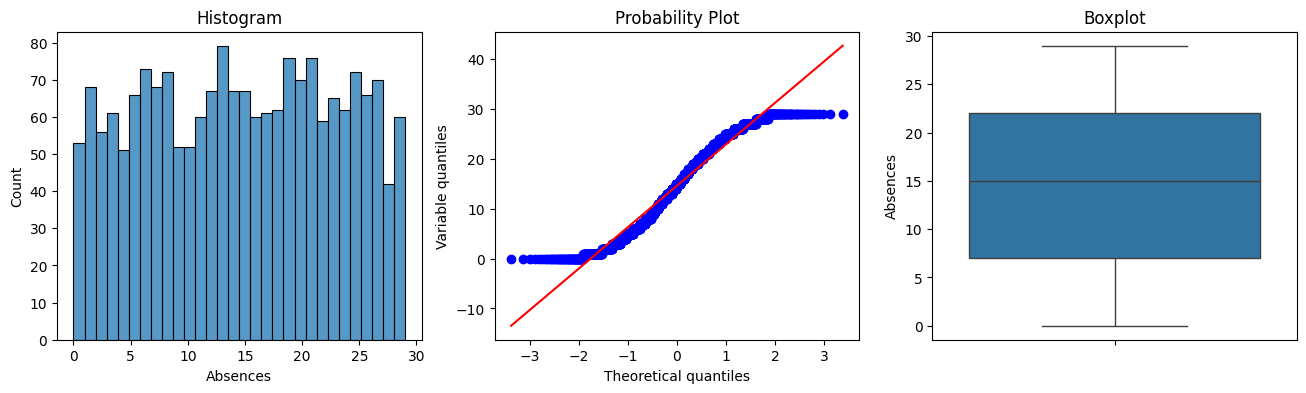

StudentID


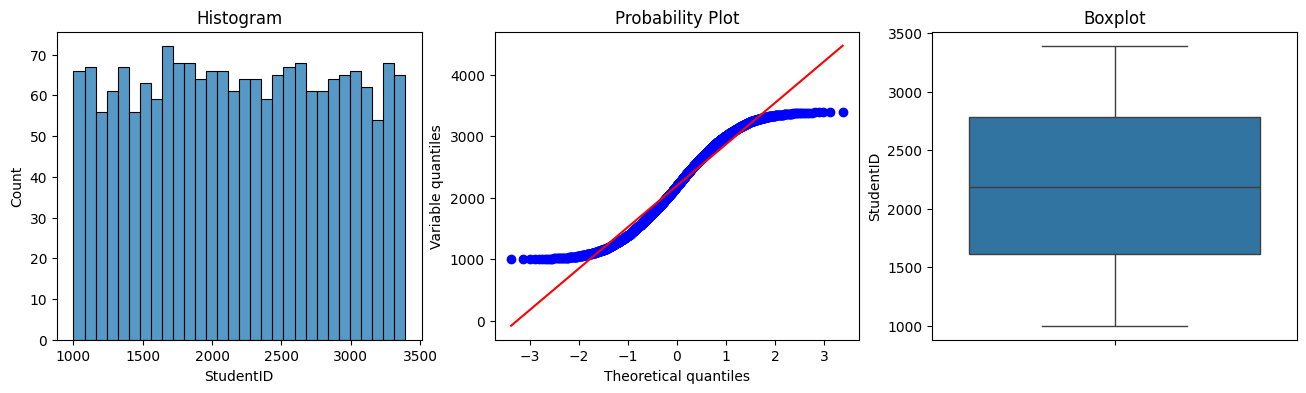

StudyTimeWeekly


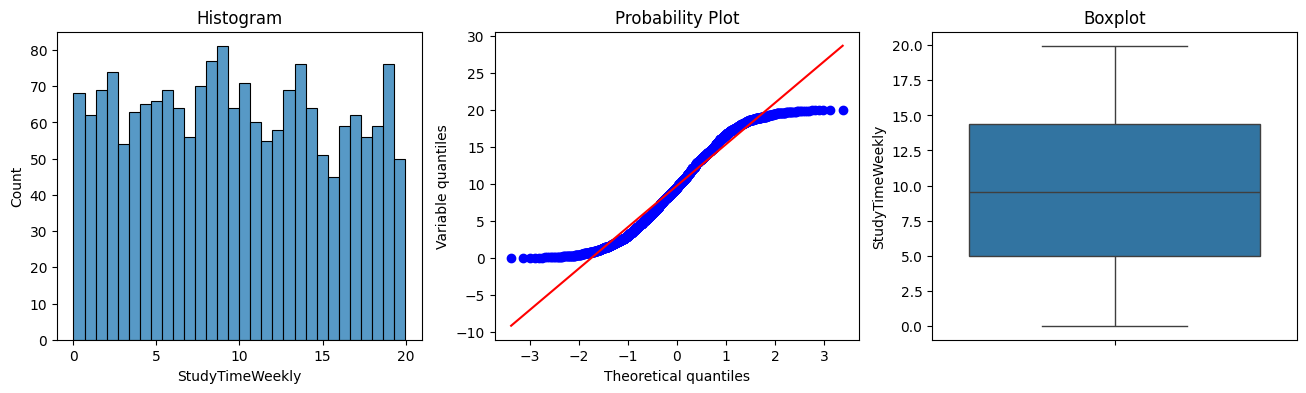

Age


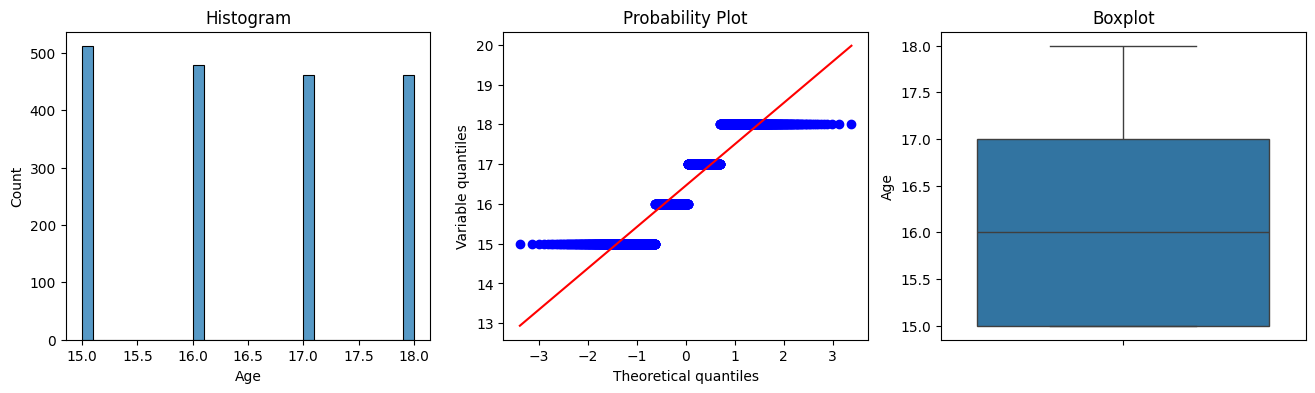

In [ ]:
# memvisualisasikan outlier
column_to_check = {'StudentID', 'Age', 'StudyTimeWeekly','Absences'}
for col in column_to_check:
    print(col)
    check_plot(X_train, col)

There are **no outliers** in the data, so the process can proceed to the next stage.

### Apply Transformer to Train and Test Data

In [ ]:
preprocessor.fit_transform(X_train)

array([[1.        , 0.90733924, 0.82758621, 1.        ],
       [0.33333333, 0.12330621, 0.65517241, 1.        ],
       [0.66666667, 0.17276063, 0.86206897, 1.        ],
       ...,
       [0.33333333, 0.17858098, 0.48275862, 0.75      ],
       [1.        , 0.22016369, 0.68965517, 1.        ],
       [1.        , 0.27151754, 0.93103448, 1.        ]])

In [ ]:
preprocessor.transform(X_test)[0]

array([0.       , 0.0063993, 0.5862069, 1.       ])

## Random Forest

### Create Random Forest pipeline

https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# TODO: create a function to create a random forest pipeline
def create_random_forest_pipeline(hyperparams):
    preprocessor = create_preprocessor()
    regressor = RandomForestRegressor(**hyperparams,
                                        random_state=42)
    rf_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', regressor)
        ])
    return rf_pipeline

hyperparams = {"n_estimators": 50, "max_depth": 50, "max_features": "log2"}
rf_pipeline = create_random_forest_pipeline(hyperparams)

In [ ]:
rf_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'StudyTimeWeekly',
                                                   'Absences',
                                                   'GradeClass'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=50, max_features='log2',
                                       n_estimators=50, random_state=42))])

### Train model

In [ ]:
from sklearn.metrics import mean_squared_error

# TODO: train the model and calculate the loss
rf_pipeline.fit(X_train, y_train)

# Estimate predictions on train and test dataset
train_preds = rf_pipeline.predict(X_train)
test_preds = rf_pipeline.predict(X_test)

# Calculate train and test loss using Mean Squared Error
train_loss = mean_squared_error(y_train, train_preds)
test_loss = mean_squared_error(y_test, test_preds)

print(f"Train MSE: {train_loss}")
print(f"Test MSE: {test_loss}")


Train MSE: 0.01107080878686807
Test MSE: 0.08323128680753787


### Plot result

Results:
Test MSE: 0.08323128680753787
Test MAE: 0.2137301459963644
R² Score: 0.8993493721310943


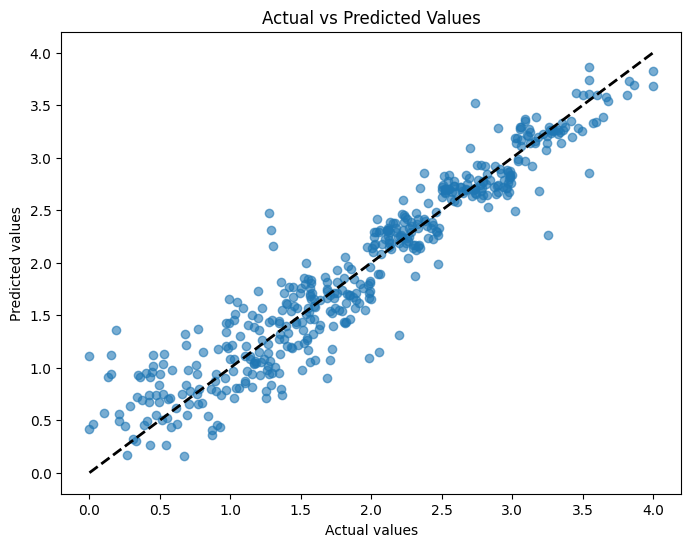

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# TODO: Predict on the test dataset
y_pred_test = rf_pipeline.predict(X_test)

# Print regression metrics
print("Results:")
print("Test MSE:", mean_squared_error(y_test, y_pred_test))
print("Test MAE:", mean_absolute_error(y_test, y_pred_test))
print("R² Score:", r2_score(y_test, y_pred_test))

# Plotting actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs Predicted Values")
plt.show()


## Confusion Matrix for Grade Class Based on GPA Predic

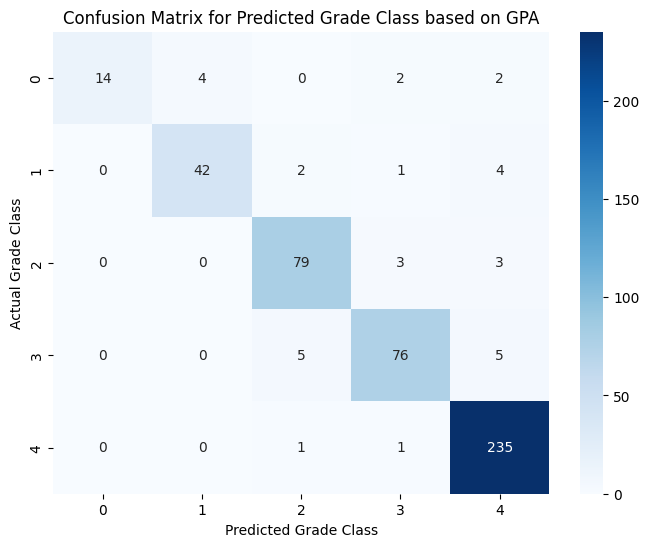

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        22
           1       0.91      0.86      0.88        49
           2       0.91      0.93      0.92        85
           3       0.92      0.88      0.90        86
           4       0.94      0.99      0.97       237

    accuracy                           0.93       479
   macro avg       0.94      0.86      0.89       479
weighted avg       0.93      0.93      0.93       479



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Fungsi untuk mengonversi GPA menjadi GradeClass
def gpa_to_grade_class(gpa):
    if gpa >= 3.5:
        return 0  # 'A'
    elif 3.0 <= gpa < 3.5:
        return 1  # 'B'
    elif 2.5 <= gpa < 3.0:
        return 2  # 'C'
    elif 2.0 <= gpa < 2.5:
        return 3  # 'D'
    else:
        return 4  # 'F'

# Mengonversi nilai GPA sebenarnya dan prediksi menjadi GradeClass
grade_class_actual = df.loc[X_test.index, 'GradeClass']
grade_class_pred = np.vectorize(gpa_to_grade_class)(y_pred_test)

# Membuat confusion matrix
conf_matrix = confusion_matrix(grade_class_actual, grade_class_pred)

# Menampilkan confusion matrix dengan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3', '4'], yticklabels=['0', '1', '2', '3', '4'])
plt.xlabel("Predicted Grade Class")
plt.ylabel("Actual Grade Class")
plt.title("Confusion Matrix for Predicted Grade Class based on GPA")
plt.show()

# Menampilkan classification report
print("Classification Report:")
print(classification_report(grade_class_actual, grade_class_pred, target_names=['0', '1', '2', '3', '4']))


## Optimization of Random Forest model with Optuna

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def objective(trial):
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    rf_pipeline = create_random_forest_pipeline(rf_params)  # Fungsi untuk membuat pipeline RandomForest

    # Menggunakan skor negatif Mean Squared Error sebagai metrik untuk regresi
    score = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    return score


In [ ]:
# TODO: play around and run the optuna optimizer
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-11-15 13:06:10,001] A new study created in memory with name: no-name-983e09bb-8bbb-422b-9f57-20d19144d136
[I 2024-11-15 13:06:11,917] Trial 0 finished with value: -0.077165119401886 and parameters: {'n_estimators': 115, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: -0.077165119401886.
[I 2024-11-15 13:06:13,296] Trial 1 finished with value: -0.0735260814986582 and parameters: {'n_estimators': 111, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: -0.0735260814986582.
[I 2024-11-15 13:06:15,244] Trial 2 finished with value: -0.07598051782370875 and parameters: {'n_estimators': 160, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: -0.0735260814986582.
[I 2024-11-15 13:06:18,165] Trial 3 finished with value: -0.0779874372

Best trial:
  Value:  -0.0735260814986582
  Params: 
    n_estimators: 111
    max_depth: 12
    min_samples_split: 9
    min_samples_leaf: 1
    max_features: sqrt
    bootstrap: True


## Evaluate with best parameters


Results After Optimize with Optuna:
Mean Squared Error (MSE): 0.07318420070718043
Mean Absolute Error (MAE): 0.20201316653199006
R² Score: 0.911499196590643


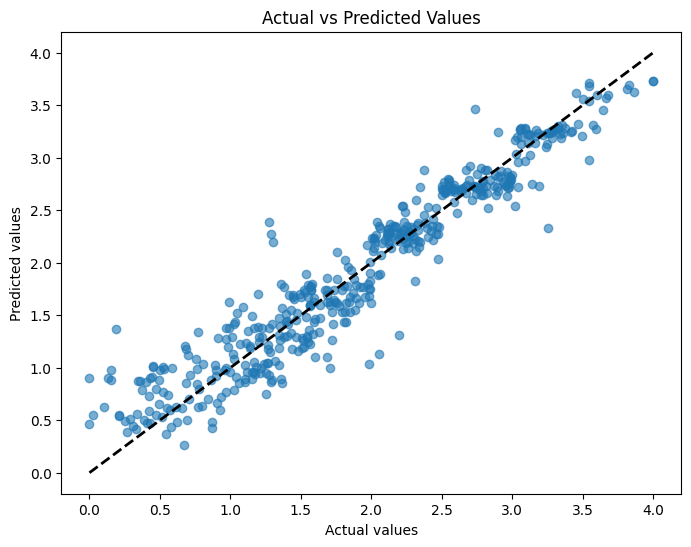

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Train RandomForestRegressor with best parameters
best_params = study.best_params
rf_model = create_random_forest_pipeline(best_params)
rf_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, rf_pred)
mae = mean_absolute_error(y_test, rf_pred)
r2 = r2_score(y_test, rf_pred)

# Print results
print("\nResults After Optimize with Optuna:")
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)

# Plotting Actual vs Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs Predicted Values")
plt.show()


CONCLUSION :

Results Before Optimize with Optuna:

1. Mean Squared Error (MSE): 0.0832
2. Mean Absolute Error (MAE): 0.2137
3. R² Score: 0.8993

Results After Optimize with Optuna:

1. Mean Squared Error (MSE): 0.0731
2. Mean Absolute Error (MAE): 0.2020
3. R² Score: 0.9114

The R² score increased to 91.15%, indicating a better fit of the model to the data. Both MSE and MAE were reduced, showcasing the effectiveness of the optimization in enhancing the model's predictive accuracy.
This demonstrates that tuning the Random Forest model's hyperparameters with Optuna significantly improved its overall performance.